## Feature Selection based on self organizing maps
This notebook presents a way to achieve feature selection through self organizing maps. The code is based in an algorithm proposed in this [paper](https://link.springer.com/chapter/10.1007%2F978-3-319-89935-0_6). **_The selection process strongly depends on two parameters_**:
1. *How well the trained SOM represents the data (since the weights are used during the selection).*
2. *A parameter "a" which is arbitarily defined by the user. Values between 0.03 and 0.06 have been proved to work well.*

For reasons of simplicity and complementarity this notebook builds on the [democracy-index example](https://github.com/JustGlowing/minisom/blob/master/examples/DemocracyIndex.ipynb). So first we load the data by exactly the same way.

In [1]:
import sys
import torch
sys.path.insert(0, '../')
%load_ext autoreload

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
%matplotlib inline

from minisom_gpu.som import MiniSom
from sklearn.preprocessing import minmax_scale, scale
%autoreload 2

device = 'cuda'

In [2]:
# download from wikipedia and reorganization
import os.path
if not os.path.isfile('democracy_index.csv'):
    wikitables = pd.read_html('https://en.wikipedia.org/wiki/Democracy_Index',
                              attrs={"class":"sortable"}, header=0)
    democracy_index = wikitables[0]
    democracy_index.columns = [c.lower().replace(' ', '_') for c in democracy_index.columns]
    democracy_index.rename(columns={'score': 'democracy_index', 
                                    'functioning_ofgovernment': 'functioning_of_government',
                                    'politicalparticipation': 'political_participation',
                                    'politicalculture': 'political_culture',
                                    'civilliberties': 'civil_liberties'}, inplace=True)
    democracy_index.category = democracy_index.category.replace('Flawed democracy[a]', 'Flawed democracy')
    democracy_index = democracy_index[:-1]
    democracy_index.to_csv('democracy_index.csv')
    print('data downloaded from Wikipedia')
else:
    # pre-downloaded file
    democracy_index = pd.read_csv('democracy_index.csv')

To demonstrate the method, we choose some of the variables that have numeric values and set "democracy index" as the target variable.

In [3]:
feature_names = ['democracy_index', 'electoral_processand_pluralism', 'functioning_of_government',
                 'political_participation', 'political_culture', 'civil_liberties']

X = democracy_index[feature_names].values
X = scale(X)

feature_df = pd.DataFrame(X, columns=feature_names)
target = feature_df.iloc[:,0]
Features = feature_df.iloc[:,1:]

A simple method to select variables is through correlation. By plotting a correlation matrix we see that all the variables are highly correlated with democracy index.

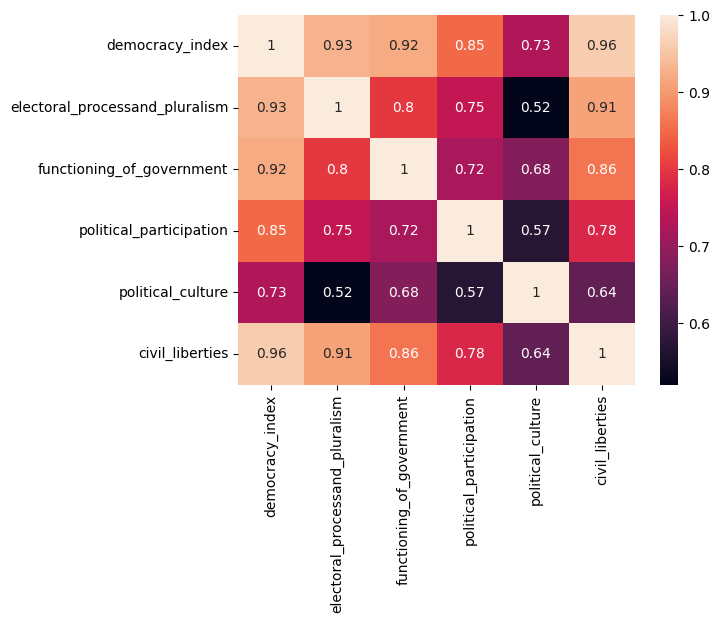

In [4]:
import seaborn as sn

feat_num = len(feature_names)

# plt.figure(figsize=(feat_num,feat_num/2))
corrMatrix = feature_df.corr().round(2)
sn.heatmap(corrMatrix, annot=True)

# plt.tight_layout()
    
plt.show()

Another way is to rank the importance of the variables in relevance with the target variable using a regression tree. 

[0.08210176 0.04062965 0.00936197 0.02779484 0.84011178]


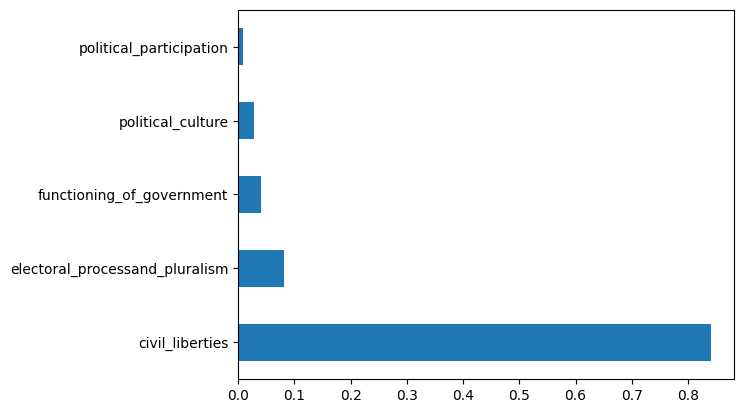

In [5]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(random_state=0)
model.fit(Features, target)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
# #plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=Features.columns)
feat_importances.nlargest(Features.shape[1]).plot(kind='barh')
plt.show()

In both of the cases above, "civil liberties" and "electoral processand pluralism" appear to be the most related variables. Let's train a self organised map.

In [6]:
category_color = {'Full democracy': 'darkgreen',
                  'Flawed democracy': 'limegreen',
                  'Hybrid regime': 'darkorange',
                  'Authoritarian': 'crimson'}
colors_dict = {c: category_color[dm] for c, dm in zip(democracy_index.country,
                                                      democracy_index.category)}

In [7]:
size = 15
som = MiniSom(size, size, len(X[0]),
              neighborhood_function='gaussian', sigma=1.5,
              random_seed=1, device=device)

X = torch.tensor(X, dtype=torch.float32, device=device)
som.pca_weights_init(X)
som.train_random(X, 1000, verbose=True)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: tensor(0.3131)


The topographic error is small so the map represents the data well.

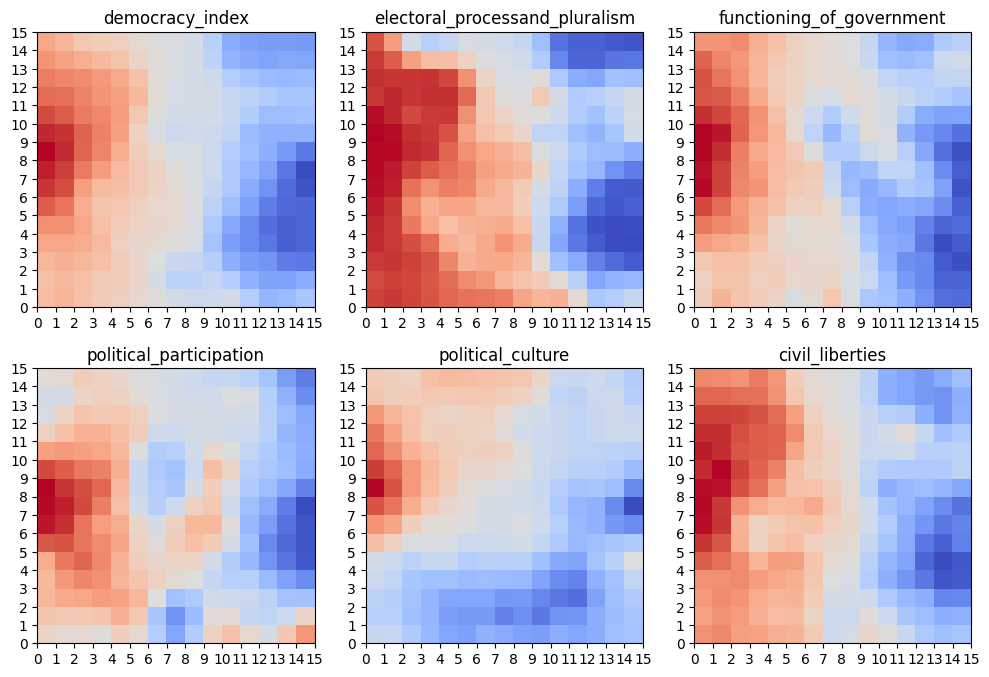

In [8]:
W = som.get_weights().numpy()
plt.figure(figsize=(10, 10))
for i, f in enumerate(feature_names):
    plt.subplot(3, 3, i+1)
    plt.title(f)
    plt.pcolor(W[:,:,i].T, cmap='coolwarm')
    plt.xticks(np.arange(size+1))
    plt.yticks(np.arange(size+1))
plt.tight_layout()
plt.show()


We see that the two varibles that ranked first in the previous methods have almost identcal planes. This is a hint that they are strongly dependent, so having both of them in a model is redundant. We are hoping that a SOM based selection can prevent that. Let's define the algorithm, and perform the selection.

In [9]:
def som_feature_selection(W, labels, target_index = 0, a = 0.04):
    """ Performs feature selection based on a self organised map trained with the desired variables

    INPUTS: W = numpy array, the weights of the map (X*Y*N) where X = map's rows, Y = map's columns, N = number of variables
            labels = list, holds the names of the variables in same order as in W
            target_index = int, the position of the target variable in W and labels
            a = float, an arbitary parameter in which the selection depends, values between 0.03 and 0.06 work well

    OUTPUTS: selected_labels = list of strings, holds the names of the selected features in order of selection
             target_name = string, the name of the target variable so that user is sure he gave the correct input
    """


    W_2d = np.reshape(W, (W.shape[0]*W.shape[1], W.shape[2])) #reshapes W into MxN assuming M neurons and N features
    target_name = labels[target_index]


    Rand_feat = np.random.uniform(low=0, high=1, size=(W_2d.shape[0], W_2d.shape[1] - 1)) # create N -1 random features
    W_with_rand = np.concatenate((W_2d,Rand_feat), axis=1) # add them to the N regular ones
    W_normed = (W_with_rand - W_with_rand.min(0)) / W_with_rand.ptp(0) # normalize each feature between 0 and 1

    Target_feat = W_normed[:,target_index] # column of target feature

    # Two conditions to check against a
    Check_matrix1 = abs(np.vstack(Target_feat) - W_normed)
    Check_matrix2 = abs(np.vstack(Target_feat) + W_normed - 1)
    S = np.logical_or(Check_matrix1 <= a, Check_matrix2 <= a).astype(int) # applie "or" element-wise in two matrices

    S[:,target_index] = 0 #ignore the target feature so that it is not picked

    selected_labels = []
    while True:

        S2 = np.sum(S, axis=0) # add all rows for each column (feature)

        if not np.any(S2 > 0): # if all features add to 0 kill
            break

        selected_feature_index = np.argmax(S2) # feature with the highest sum gets selected first

        if selected_feature_index > (S.shape[1] - (Rand_feat.shape[1] + 1)): # if random feature is selected kill
            break


        selected_labels.append(labels[selected_feature_index])

        # delete all rows where selected feature evaluates to 1, thus avoid selecting complementary features
        rows_to_delete = np.where(S[:,selected_feature_index] == 1)
        S[rows_to_delete, :] = 0

#     selected_labels = [label for i, label in enumerate(labels) if i in feature_indeces]
    return selected_labels, target_name

In [10]:
selected_features, target_name = som_feature_selection(W, feature_names, 0, 0.04)
print("Target variable: {}\nSelected features {}".format(target_name, selected_features))

Target variable: democracy_index
Selected features ['functioning_of_government', 'civil_liberties', 'political_participation']
